In [66]:
from dataclasses import dataclass
import os
import datetime
import pickle
import numpy as np
import random
import torch
import pandas as pd
from torch.utils.data import TensorDataset,Dataset
from transformers import BertTokenizer, RobertaTokenizer, BartTokenizer, AutoTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,WeightedRandomSampler
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import (
    BertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
)
from transformers import (
    RobertaForSequenceClassification,
    BartForSequenceClassification,
    AutoModelForSequenceClassification,
)
from tqdm.auto import tqdm

Model List

- "microsoft/deberta-v3-base" 
- "facebook/bart-base" 

- "google/gemma-2b"

In [67]:
news= pd.read_table("data/MINDsmall_train/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])

In [68]:
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(51282, 18881, 3107)

In [69]:
news= pd.read_table("data/MINDsmall_dev/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(42416, 15606, 2563)

In [70]:
news= pd.read_table("data/MINDlarge_dev/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(72023, 26157, 4331)

In [71]:
news= pd.read_table("data/MINDlarge_test/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(120959, 43951, 7034)

In [72]:
news= pd.read_table("data/MINDlarge_train/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(101527, 36394, 5916)

In [73]:
useful_news = news.loc[news['Category'].isin(['news','finance'])].copy(deep=True)

In [74]:
useful_news['full_text'] = useful_news['Title'].fillna(" ")+" "+useful_news['Abstract'].fillna(" ")

In [75]:
import pickle as pk

In [76]:
aug_topic_ls = pk.load( open('./data/aug/first_300_topic2.pkl','rb'))

In [77]:
aug_df = pk.load(open('./data/aug/full_small_news_aug.pkl','rb'))

In [78]:
aug_df.head()

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,full_text,already_done,enhanced_text,enhanced_id,semi_enhanced_text,change_topic_id,changed_topic_text,from_large
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...,True,As the conflict in Ukraine continues to escal...,0.0,The conflict in Ukraine continues to escalate...,7.0,Ukraine's Lt. Ivan Molchanets Faces Financial...,True
7,N59295,news,newsworld,Chile: Three die in supermarket fire amid prot...,Three people have died in a supermarket fire a...,https://assets.msn.com/labs/mind/AAJ43pw.html,"[{""Label"": ""Chile"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Santiago"", ""Type"": ""G"", ""WikidataI...",Chile: Three die in supermarket fire amid prot...,True,Chile: Three die in supermarket fire amid ong...,1.0,"According to unconfirmed reports, three indiv...",7.0,Chile's Santiago-Based Bankruptcy: A Lesson L...,True
9,N39237,news,newsscienceandtechnology,"How to report weather-related closings, delays","When there are active closings, view them here...",https://assets.msn.com/labs/mind/AAlErhA.html,[],"[{""Label"": ""WXII-TV"", ""Type"": ""M"", ""WikidataId...","How to report weather-related closings, delays...",True,WXII 12 News receives numerous phone calls an...,2.0,WXII 12 News receives numerous phone calls an...,6.0,WXII 12 News: New Tariffs on Chinese Goods Co...,True
20,N9786,news,newspolitics,Elijah Cummings to lie in state at US Capitol ...,"Cummings, a Democrat whose district included s...",https://assets.msn.com/labs/mind/AAJgNxm.html,"[{""Label"": ""Elijah Cummings"", ""Type"": ""P"", ""Wi...","[{""Label"": ""Elijah Cummings"", ""Type"": ""P"", ""Wi...",Elijah Cummings to lie in state at US Capitol ...,True,"Elijah Cummings, a prominent Democrat whose d...",3.0,An event that impacts a significant number of...,0.0,Elijah Cummings' Impact on Political and Econ...,True
23,N42474,news,newsbusiness,Trump's Trustbusters Bring Microsoft Lessons t...,DOJ's Makan Delrahim and the FTC's Joe Simons ...,https://assets.msn.com/labs/mind/AACI1SK.html,"[{""Label"": ""Big Four tech companies"", ""Type"": ...","[{""Label"": ""Makan Delrahim"", ""Type"": ""P"", ""Wik...",Trump's Trustbusters Bring Microsoft Lessons t...,True,The recent decision by the DOJ's Makan Delrah...,3.0,The recent decision by the DOJ's Makan Delrah...,1.0,"""Trump's Big Lessons on Natural Disasters: Ho...",True


In [79]:
class CFG:
    wandb = True
    competition = "PPPM"
    _wandb_kernel = "nakama"
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model = "microsoft/deberta-v3-small"
    scheduler = "linear"  #'cosine' # ['linear', 'cosine','constant','plateau']
    batch_scheduler = True
    num_cycles = 1.0
    num_warmup_steps = 0
    epochs = 5
    encoder_lr = 7e-5#5e-5  # lr 5e-5 accumulation 4 batch 8 wd 0.003produces overfittin in the first epch
    decoder_lr = 3e-5  # 3e-5# 8e-6
    min_lr = 1e-7
    eps = 1e-8
    betas = (0.9, 0.999)
    batch_size = 8 #36
    fc_dropout = 0.2
    target_size = 1
    max_len = 320
    weight_decay = 0.003#0.01  # 0.002#0.015#0.005#0.001#0.00005
    gradient_accumulation_steps = 1
    max_grad_norm = 60  # 200#500 #10#100#1000#150#1000
    seed = 42
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True


In [80]:
CFG= dict(wandb = True,
    competition = "PPPM",
    _wandb_kernel = "nakama",
    debug = False,
    apex = True,
    print_freq = 100,
    num_workers = 4,
    model = "microsoft/deberta-v3-small",
    scheduler = "linear" , #'cosine' # ['linear', 'cosine','constant','plateau'],
    batch_scheduler = True,
    num_cycles = 1.0,
    num_warmup_steps = 0,
    epochs = 5,
    encoder_lr = 7e-5 ,#5e-5  # lr 5e-5 accumulation 4 batch 8 wd 0.003produces overfittin in the first epch,
    decoder_lr = 3e-5 , # 3e-5# 8e-6,
    min_lr = 1e-7,
    eps = 1e-8,
    betas = (0.9, 0.999),
    batch_size = 8,#36,
    fc_dropout = 0.2,
    target_size = 1,
    max_len = 320,
    weight_decay = 0.003,#0.01  # 0.002#0.015#0.005#0.001#0.00005,
    gradient_accumulation_steps = 1,
    max_grad_norm = 60 , # 200#500 #10#100#1000#150#1000,
    seed = 42,
    n_fold = 5,
    trn_fold = [0, 1, 2, 3, 4],
    train = True)


In [81]:
model_name = "derbertav3_base_oversampling"
model_hug = "microsoft/deberta-v3-base"
max_seq_length = 512
batch_size = 16
epoch = 15
lr = 1e-5
seed_val = 42


In [82]:
class ClassificationAugmentedTrainDataset(Dataset):
    def __init__(self,pos_data,neg_data):

        self.pos_data = pos_data
        self.neg_data = neg_data
        self.columns =  ['labels', 'input_ids', 'attention_masks']

    def __len__(self):
        return (len(self.pos_data))*2

    def __getitem__(self, index):

        if index%2==0:

            text = self.pos_data[index//2]
        
        else:
            idx = np.random.randint(len(self.neg_data))
            text = self.neg_data[idx]
    
        
        
        return {'text':text.strip() ,"labels":index%2 }

In [91]:
tokenizer = AutoTokenizer.from_pretrained(CFG['model'])

/home/felipe/anaconda3/envs/cuda_12.1/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [19]:

tr_dataset = ClassificationAugmentedTrainDataset([text for text,_ in aug_topic_ls],useful_news['full_text'].to_list())





In [21]:
tr_dataset = ClassificationAugmentedTrainDataset(aug_df.loc[~aug_df['changed_topic_text'].isna(),'changed_topic_text'].to_list(),useful_news['full_text'].to_list())

In [22]:
aug_df['changed_topic_text']

2         Ukraine's Lt. Ivan Molchanets Faces Financial...
7         Chile's Santiago-Based Bankruptcy: A Lesson L...
9         WXII 12 News: New Tariffs on Chinese Goods Co...
20        Elijah Cummings' Impact on Political and Econ...
23        "Trump's Big Lessons on Natural Disasters: Ho...
                               ...                        
51271     Turkish Army Deploys to Help Rebuild Syria Af...
51272     Dayton-Wright Brothers Airport Faces Uncertai...
51273     John Catsimatidis and Guardian Angels Join Fo...
51274     US Forest Service and Georgia's Chattahoochee...
51275     Realme's Profitability Takes a Hit as India's...
Name: changed_topic_text, Length: 18881, dtype: object

In [23]:
len(tr_dataset)

37762

In [24]:
tr_dataset[599]

{'text': "Top Chicago news: Black customers told to switch tables; cop suspected of slapping cop; more Here's the most recent top news in Chicago; see what headlines are trending among local readers, with links to full articles.",
 'labels': 1}

In [25]:
tr_dataset[11]

{'text': 'Small plane crashes into California home; 2 residents escape Authorities say a single-engine plane has crashed into a house in Southern California, sparking a house fire . Police say a father and child were in the home at the time and escaped without injuries. (Nov. 7)',
 'labels': 1}

In [26]:
dl = DataLoader(tr_dataset,batch_size=CFG['batch_size'],shuffle=True)

In [27]:
for batch in dl:
    break

In [28]:
batch

{'text': ["Jamestown's Infrastructure Takes a Hit from Hurricane\n\nJamestown, a small coastal town in North Carolina, was hit hard by Hurricane Florence in September 2018. The storm caused significant damage to the town's infrastructure, including roads, bridges, and power lines. This disrupted supply chains and caused significant economic losses for the town.\n\nThe Guilford County Sheriff's Department was also affected by the hurricane. The department had to redirect resources to assist with emergency response efforts in Jamestown and other affected areas. This diversion of resources caused delays in response times to other incidents in the county.\n\nThe value of investments in Jamestown and the surrounding area was also affected by the hurricane. The stock market saw increased volatility as investors reacted to the news of the damage caused by the storm. This volatility continued for several weeks after the hurricane passed.\n\nDespite the challenges faced by Jamestown and the Gui

In [29]:
res = tokenizer(batch['text'],padding=True,return_tensors='pt',)

In [30]:
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "lr": encoder_lr,
            "weight_decay": weight_decay,
        },
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "lr": encoder_lr,
            "weight_decay": 0.0,
        },
        # {'params': [p for n, p in model.named_parameters() if "model" not in n],
        #     'lr': decoder_lr, 'weight_decay':  weight_decay}
    ]
    return optimizer_parameters


# optimizer_parameters = get_optimizer_params(
#     model,
#     encoder_lr=CFG.encoder_lr,
#     decoder_lr=CFG.decoder_lr,
#     weight_decay=CFG.weight_decay,
# )


#optimizer = Adam(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)


# optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

#num_train_steps = int(EPOCHS * len(dl) / accumulation_steps)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.3 * num_train_optimization_steps, num_training_steps = num_train_optimization_steps)
#print(num_train_steps)


def get_scheduler(cfg, optimizer, num_train_steps):
    # if cfg.scheduler == 'linear':
    #     scheduler = transformers.get_linear_schedule_with_warmup(
    #         optimizer, num_warmup_steps=0.2 * num_train_steps, num_training_steps=num_train_steps
    #     )
    if cfg.scheduler == "linear":
        scheduler = transformers.get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == "cosine":
        scheduler = transformers.get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0.2 * num_train_steps,
            num_training_steps=int(num_train_steps * 1.1),
            num_cycles=cfg.num_cycles,
        )
    elif cfg.scheduler == "constant":
        scheduler = transformers.get_constant_schedule_with_warmup(
            optimizer, num_warmup_steps=0.3 * num_train_steps
        )

    elif cfg.scheduler == "plateau":
        scheduler = transformers.ReduceLronPlateau(
            optimizer, num_warmup_steps=0.3 * num_train_steps
        )

    return scheduler


#scheduler = get_scheduler(CFG, optimizer, num_train_steps)

In [31]:
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1e-2,
        adv_eps=9e-4,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler
        self.loss = torch.nn.CrossEntropyLoss()
    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                tr_logits = self.model(x,attention_mask)['logits']
                adv_loss =  self.loss(tr_logits,y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        #e=1e-3
        #e=1e-3
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}


In [32]:
def eval_result( labels,preds):
    """ Calculate the accuracy, f1, precision, recall of our predictions vs labels
    """
    if len(preds.shape) ==2:
        y_pred = np.argmax(preds, axis=1).flatten()
    else:
        y_pred=preds
    y_true = labels.flatten()

    precision = precision_score(y_true, y_pred,zero_division=1)
    recall = recall_score(y_true, y_pred,zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro',zero_division=1)
    accuracy = np.sum(y_pred == y_true) / len(y_true) 

    return (precision, recall, f1, accuracy)

from sklearn.metrics import classification_report

In [33]:
def train_model(
    model_name,
    model,
    train_dataloader,
    val_dataloader,
    scheduler,
    optimizer,
    criterion,
    epochs,
    lr,
    fold=0,
):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    
    scaler = torch.cuda.amp.GradScaler()
    # For each epoch...
    for epoch in range(epochs):

        total_train_loss = 0
        train_n_correct = 0
        nb_tr_examples = 0

        model.train()

        for step, batch in tqdm(
            enumerate(train_dataloader),
            total=len(train_dataloader),
            desc=f"Train epoch {epoch+1}/{epochs}",
        ):

            batch.update(tokenizer(batch['text'],max_length=512,padding=True,truncation=True,return_tensors='pt'))
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            model.zero_grad()
            with torch.cuda.amp.autocast():
                result = model(b_input_ids, attention_mask=b_input_mask)

                loss = criterion(result.logits, b_labels)

                
            #loss.backward()
            scaler.scale(loss).backward()
            if step % accumulation_steps == 0 or step == len(train_dataloader) - 1:
            # Unscales the gradients of optimizer's assigned params in-place
            #    scaler.unscale_(optimizer)

            #                   # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
            #    torch.nn.utils.clip_grad_norm_(net.parameters(), CFG.max_grad_norm)

                scaler.step(optimizer)
                scaler.update()
                # optimizer.step()
                scheduler.step()
                optimizer.zero_grad(set_to_none=True)
                
            total_train_loss+=loss.item()
            logits = result.logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()
            _, _, _, accuracy = eval_result(label_ids,logits)
            train_n_correct += accuracy
            nb_tr_examples += b_input_ids.size(0)

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_acc = train_n_correct / len(train_dataloader)

        print(
            "Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f} ".format(
                epoch + 1, epochs, avg_train_loss, train_acc
            )
        )

        model.eval()

        test_results = []
        test_labels = []
        total_val_loss=0
        test_results_predicted_lavels = []
        test_results_predicted_lavels2 = []
        test_results_predicted_lavels3 = []
        for batch in tqdm(val_dataloader, desc="Eval model"):
            #'labels', 'input_ids', 'attention_masks'

            batch.update(tokenizer(batch['text'],max_length=512,padding=True,truncation=True,return_tensors='pt'))
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            with torch.no_grad():
                result = model(
                    b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                    return_dict=True,
                )
                loss = criterion(result.logits, b_labels)
            total_val_loss += loss.item()
            logits = torch.softmax(result.logits,axis=1)#result.logits
            logits = logits.detach().cpu().numpy()
            test_results.extend(logits.tolist())
            tmp = np.asarray(logits.tolist())

            # test_results_predicted_lavels.extend(np.max(tmp,axis=1).flatten())

            test_results_predicted_lavels.extend(tmp[:,1]>0.15)
            test_results_predicted_lavels2.extend(tmp[:,1]>0.5)
            test_results_predicted_lavels3.extend(tmp[:,1]>0.7)
            
            avg_val_loss = total_val_loss / len(val_dataloader)
            label_ids = b_labels.to("cpu").numpy()
            test_labels.extend(label_ids)

        print(
            classification_report(
                np.asarray(test_labels), np.asarray(test_results_predicted_lavels)
            )
        )
        (precision, recall, f1, accuracy) = eval_result(
            np.asarray(test_labels), np.asarray(test_results_predicted_lavels)
        )

        print(
            "Epoch [{}/{}], Test Loss: {:.4f},Test Precision: {:.4f}, Test Recall: {:.4f}, Test Macro F1: {:.4f}, Test Accuracy: {:.4f} ".format(
                epoch + 1, epochs, avg_val_loss, precision, recall, f1, accuracy
            )
        )


        print(classification_report( np.asarray(test_labels), np.asarray(test_results_predicted_lavels2)))
        (precision, recall, f1, accuracy) = eval_result(np.asarray(test_labels), np.asarray(test_results_predicted_lavels2))

        print('Test Precision: {:.4f}, Test Recall: {:.4f}, Test Macro F1: {:.4f}, Test Accuracy: {:.4f} ' .format(precision, recall, f1, accuracy))

        (precision, recall, f1, accuracy) = eval_result(np.asarray(test_labels), np.asarray(test_results_predicted_lavels3))

        print('Test Precision: {:.4f}, Test Recall: {:.4f}, Test Macro F1: {:.4f}, Test Accuracy: {:.4f} ' .format(precision, recall, f1, accuracy))

        model.save_pretrained(f"saved_model/{model_name}_{epoch}/{epochs}e_{lr}lr_f{fold}")

    print("Training complete!")

   
    # model.save_pretrained(f"drive/MyDrive/IGLU-cq-data/{model_name}_{epochs}e_{lr}lr")


In [20]:
device="cuda:2"

In [21]:
aug_topic_ls = aug_df.loc[~aug_df['changed_topic_text'].isna(),'changed_topic_text'].to_list()

In [36]:

tr_dataset = ClassificationAugmentedTrainDataset([text for text in aug_topic_ls[:-50]],useful_news['full_text'].to_list()[:-500])
val_dataset = ClassificationAugmentedTrainDataset([text for text in aug_topic_ls[-50:]],useful_news['full_text'].to_list()[-500:])





In [37]:
aug_df.columns

Index(['News ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL',
       'Title Entities', 'Abstract Entities', 'full_text', 'already_done',
       'enhanced_text', 'enhanced_id', 'semi_enhanced_text', 'change_topic_id',
       'changed_topic_text', 'from_large'],
      dtype='object')

In [38]:
common_topic_news = aug_df.loc[~aug_df['enhanced_text'].isna(),'enhanced_text'].to_list() + aug_df.loc[~aug_df['semi_enhanced_text'].isna(),'semi_enhanced_text'].to_list()

In [39]:

tr_dataset = ClassificationAugmentedTrainDataset([text for text in aug_topic_ls[:-50]],common_topic_news[:-500])
val_dataset = ClassificationAugmentedTrainDataset([text for text in aug_topic_ls[-50:]],common_topic_news[-500:])





In [40]:
len(common_topic_news)

37762

In [41]:
val_dataset[11]

{'text': "Texas Republican Congressman John Smith has once again called for the protection of the identity of the whistleblower who exposed corruption in the Ukraine government. Smith, who has been a vocal advocate for transparency and accountability in government, believes that the whistleblower's identity should be kept confidential to prevent retaliation and ensure their safety.\n\nAccording to Smith, the whistleblower's allegations of corruption and abuse of power in the Ukraine government have been largely ignored by the international community, despite the potential consequences for global stability and security. Smith believes that the whistleblower's identity should be protected to encourage others to come forward and expose corruption, and to ensure that those responsible for wrongdoing are held accountable.\n\nSmith has also called for increased funding and resources to be allocated to investigating corruption in the Ukraine government. He believes that this will help to root

In [42]:
dl = DataLoader(tr_dataset,batch_size=CFG['batch_size'],shuffle=True)

In [43]:
train_dataloader=dl
val_dataloader=DataLoader(val_dataset,batch_size=CFG['batch_size'],shuffle=True)

In [44]:
epochs=5
fold=0
accumulation_steps=1

In [45]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_hug, num_labels=2)
model.to(device)

optimizer = AdamW(
    model.parameters(), lr=lr, weight_decay=0.05  # 0.03 73.4 ar epoch 6
)
num_train_steps = int(epochs * len(train_dataloader) / accumulation_steps)

criterion = CrossEntropyLoss()
total_steps = len(train_dataloader) * epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

# Train Model
train_model(
    model_name,
    model,
    train_dataloader,
    val_dataloader,
    scheduler,
    optimizer,
    criterion,
    epochs,
    lr,
    fold,
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/felipe/anaconda3/envs/cuda_12.1/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train epoch 1/5:   0%|          | 0/4708 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.0196, Train Accuracy: 0.9924 


Eval model:   0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Epoch [1/5], Test Loss: 0.0000,Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 


Train epoch 2/5:   0%|          | 0/4708 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.0033, Train Accuracy: 0.9991 


Eval model:   0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Epoch [2/5], Test Loss: 0.0000,Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 


Train epoch 3/5:   0%|          | 0/4708 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.0010, Train Accuracy: 0.9997 


Eval model:   0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Epoch [3/5], Test Loss: 0.0000,Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 


Train epoch 4/5:   0%|          | 0/4708 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.9998 


Eval model:   0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Epoch [4/5], Test Loss: 0.0000,Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 


Train epoch 5/5:   0%|          | 0/4708 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.0001, Train Accuracy: 1.0000 


Eval model:   0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Epoch [5/5], Test Loss: 0.0000,Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
Test Precision: 1.0000, Test Recall: 1.0000, Test Macro F1: 1.0000, Test Accuracy: 1.0000 
Training complete!


In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_hug, num_labels=2)
model.to(device)

optimizer = AdamW(
    model.parameters(), lr=lr, weight_decay=0.05  # 0.03 73.4 ar epoch 6
)
num_train_steps = int(epochs * len(train_dataloader) / accumulation_steps)

criterion = CrossEntropyLoss()
total_steps = len(train_dataloader) * epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

# Train Model
train_model(
    model_name,
    model,
    train_dataloader,
    val_dataloader,
    scheduler,
    optimizer,
    criterion,
    epochs,
    lr,
    fold,
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/felipe/anaconda3/envs/cuda_12.1/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


NameError: name 'epochs' is not defined

In [92]:
device='cuda:2'

In [84]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("/home/felipe/New Recommendations/saved_model/derbertav3_base_oversampling_2/5e_1e-05lr_f0")
model.to(device)


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [85]:
all_pred = []

In [24]:



model.eval()
for i in range((len(useful_news)//32)+1):
    arts = useful_news['full_text'].iloc[i*32:(i+1)*32].to_list()
    batch = tokenizer(arts, max_length=512,padding=True,truncation=True,return_tensors='pt')

    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        pred = model(**batch)['logits'].detach().cpu()
    all_pred.extend( torch.sigmoid(pred[:,1]).tolist())

In [25]:
all_pred

[0.6870428323745728,
 0.9982751607894897,
 0.9917486906051636,
 0.9977487921714783,
 0.998384952545166,
 0.9982522130012512,
 0.7957712411880493,
 0.9650083184242249,
 0.998375654220581,
 0.9981517195701599,
 0.9962421655654907,
 0.9984028935432434,
 0.9975276589393616,
 0.993701696395874,
 0.9979162812232971,
 0.9960952401161194,
 0.9982749223709106,
 0.9983123540878296,
 0.9960820078849792,
 0.9981682300567627,
 0.8657504916191101,
 0.9981585144996643,
 0.9980448484420776,
 0.9975804090499878,
 0.7268761396408081,
 0.9982341527938843,
 0.9977726340293884,
 0.9975544810295105,
 0.9846833348274231,
 0.9982106685638428,
 0.997996985912323,
 0.9760571718215942,
 0.995753288269043,
 0.9980668425559998,
 0.9872516393661499,
 0.9983460903167725,
 0.998455286026001,
 0.9400443434715271,
 0.9976702332496643,
 0.998188316822052,
 0.9980310797691345,
 0.9966610670089722,
 0.9977587461471558,
 0.9982210993766785,
 0.9981786012649536,
 0.9982323050498962,
 0.9768893122673035,
 0.9918563365936279,

In [26]:
useful_news['rare_event_score'] = all_pred

In [27]:
rare_events_news  = useful_news.loc[useful_news['rare_event_score'] < 0.1,'News ID'].to_list() 

In [28]:
len(rare_events_news)

77

In [29]:
len(useful_news)

36394

In [30]:
useful_news.loc[useful_news['rare_event_score'] < 0.07].sort_values('rare_event_score').to_pickle('classified_like_impactful_events.pkl')

In [31]:
int_val = pd.read_csv("miner/data/valid/behaviors.tsv",sep='\t',header=None,names=["Impression ID","User ID","Time","History","Impressions" ])

In [32]:
impression_w_rare= int_val['Impressions'].apply(lambda x: any([ article in x for article in rare_events_news]))

In [33]:
impression_w_rare.sum()

40

In [34]:
int_val.loc[impression_w_rare].to_csv("miner/data/valid_hard/behaviors.tsv",sep='\t',index=False,header=False)

In [35]:
1

1

In [86]:
news= pd.read_table("data/MINDsmall_dev/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(42416, 15606, 2563)

In [87]:
useful_news = news.loc[news['Category'].isin(['news','finance'])].copy(deep=True)

In [88]:
useful_news['full_text'] = useful_news['Title'].fillna(" ")+" "+useful_news['Abstract'].fillna(" ")

In [89]:
all_pred = []

In [93]:



model.eval()
for i in range((len(useful_news)//32)+1):
    arts = useful_news['full_text'].iloc[i*32:(i+1)*32].to_list()
    batch = tokenizer(arts, max_length=512,padding=True,truncation=True,return_tensors='pt')

    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        pred = model(**batch)['logits'].detach().cpu()
    all_pred.extend( torch.sigmoid(pred[:,1]).tolist())

In [94]:
all_pred

[0.9982751607894897,
 0.9917488098144531,
 0.9977487921714783,
 0.9982522130012512,
 0.7957712411880493,
 0.9962421655654907,
 0.9975276589393616,
 0.9979162812232971,
 0.9982749223709106,
 0.9983123540878296,
 0.9960820078849792,
 0.9981682300567627,
 0.9982341527938843,
 0.9982106685638428,
 0.997996985912323,
 0.9760572910308838,
 0.9872516393661499,
 0.9983460903167725,
 0.998455286026001,
 0.9976702332496643,
 0.998188316822052,
 0.9980310797691345,
 0.9981786012649536,
 0.9982323050498962,
 0.9918563365936279,
 0.998261034488678,
 0.9852035045623779,
 0.9782911539077759,
 0.998132050037384,
 0.997514009475708,
 0.9977555871009827,
 0.9984227418899536,
 0.9983376264572144,
 0.9971664547920227,
 0.9983508586883545,
 0.9981856942176819,
 0.9973810315132141,
 0.998271107673645,
 0.9914047718048096,
 0.9356448650360107,
 0.9976075887680054,
 0.9923284649848938,
 0.9944549202919006,
 0.9976958632469177,
 0.9917405843734741,
 0.997825026512146,
 0.9980085492134094,
 0.9983735084533691,


In [95]:
useful_news['rare_event_score'] = all_pred

<Axes: >

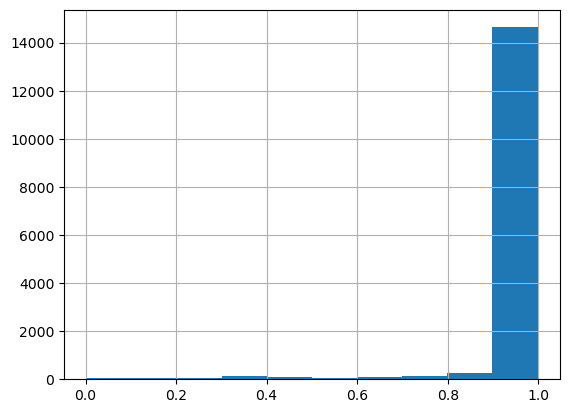

In [96]:
useful_news['rare_event_score'].hist() 

In [101]:
useful_news.sort_values("rare_event_score")['Abstract'].head(50).values

array(['Elizabeth Warren fears Wall Street will use the recent mayhem in overnight lending markets to convince Washington to relax regulations aimed at preventing a repeat of the 2008 crisis.',
       'As investors weigh up the value of Saudi energy colossus Aramco ahead of its IPO next month, the global drive to contain climate change and waning demand for fossil fuels are seen as key risks. "There\'s no doubt that environmental, social and governance risks will factor in the calculations of investors looking at the Saudi Aramco IPO," said Torbjorn Soltvedt from Verisk Maplecroft, a UK-based strategic consulting firm.',
       "The trade war and China's economic shift made 2018 a tough year for global shipping and will continue to reverberate through the industry, according to the United Nations Conference on Trade and Development.",
       "Faraday Future founder Jia Yueting has filed for Chapter 11 bankruptcy in a bid to settle his exorbitant personal debts. The move is part of a la

In [100]:
useful_news.sort_values("rare_event_score")['Abstract'].tail(30).values

array(['GREENSBORO, N.C.   A crash on Meadowood Street left at least one person dead and the road closed as police investigate, according to Greensboro police. Police believe a driver was helping another driver move a broken down vehicle off the road when they were hit by a car between Edith Lane and West Wendover Avenue. Officers have not identified the victim and no charges have been filed. Police ...',
       'GREENSBORO, N.C.   The funeral for Kay Hagan, a former U.S. Senator from North Carolina and Shelby-native, is scheduled for Sunday after she died Tuesday, according to the Greensboro Jewish Federation. The funeral service, which is open to the public, will begin at 2 p.m. Sunday at First Presbyterian Chruch at 617 N. Elm St. in Greensboro. A visitation for family will follow. "We are ...',
       "PHOENIX (3TV/CBS 5)-- A staggering update to a story Arizona's Family has been following closely; Valley firefighters getting their cancer claims denied by cities, even though the cl

In [140]:
rare_events_news  = useful_news.loc[useful_news['rare_event_score'] < 0.2,'News ID'].to_list() 

In [141]:
len(rare_events_news)

106

In [142]:
len(useful_news)

26157

In [143]:
len(useful_news)

26157

In [55]:
useful_news.loc[useful_news['rare_event_score'] < 0.2].sort_values('rare_event_score').to_pickle('classified_like_impactful_events_hard_test_from_dev.pkl')

In [53]:
int_val = pd.read_csv("miner/data/test/behaviors.tsv",sep='\t',header=None,names=["Impression ID","User ID","Time","History","Impressions" ])

In [54]:
impression_w_rare= int_val['Impressions'].apply(lambda x: any([ article in x for article in rare_events_news]))

In [55]:
(impression_w_rare & int_val['Impressions'].str.contains('-1')).sum()

7793

In [56]:
int_val.loc[impression_w_rare & int_val['Impressions'].str.contains('-1')].to_csv("miner/data/test_hard/behaviors.tsv",sep='\t',index=False,header=False)

In [57]:
len(int_val)

64490

In [58]:
int_val.loc[impression_w_rare& int_val['Impressions'].str.contains('-1'),'Impressions'].str.split().apply(len).sum()

165313

<Axes: >

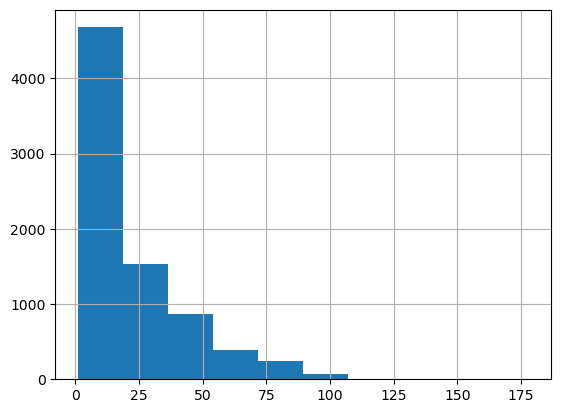

In [59]:
int_val.loc[impression_w_rare& int_val['Impressions'].str.contains('-1'),'Impressions'].str.split().apply(len).hist()

In [60]:
int_val.loc[impression_w_rare,'Impressions'].head().values

array(['N21941-0 N24802-0 N29091-0 N45057-0 N4733-0 N52492-0 N6074-0 N60762-0',
       'N11390-0 N24802-1 N29091-0',
       'N20764-0 N24802-1 N28640-1 N29091-0 N45057-0 N52492-0 N6074-0 N60762-0',
       'N11390-0 N17405-0 N24802-1 N2716-0 N29091-0 N3159-0 N37577-0 N3806-0 N46495-0 N4733-0 N51104-0 N53298-0 N54125-0 N5507-0 N64724-0 N6858-0',
       'N11390-1 N12446-0 N21681-0 N24802-1 N26572-0 N29091-0 N3168-0 N31884-0 N33176-0 N38951-0'],
      dtype=object)

In [61]:
res = sorted(zip(useful_news['full_text'].iloc[:len(all_pred)].to_list(),all_pred),key=lambda x : x[1])

In [31]:
res[:50]

[('Elizabeth Warren alarmed about turmoil in overnight lending markets Elizabeth Warren fears Wall Street will use the recent mayhem in overnight lending markets to convince Washington to relax regulations aimed at preventing a repeat of the 2008 crisis.',
  0.0022459421306848526),
 ('Climate change looms over giant Saudi energy IPO As investors weigh up the value of Saudi energy colossus Aramco ahead of its IPO next month, the global drive to contain climate change and waning demand for fossil fuels are seen as key risks. "There\'s no doubt that environmental, social and governance risks will factor in the calculations of investors looking at the Saudi Aramco IPO," said Torbjorn Soltvedt from Verisk Maplecroft, a UK-based strategic consulting firm.',
  0.004840041510760784),
 ("How the Trade War and a Changing China Are Roiling World Shipping The trade war and China's economic shift made 2018 a tough year for global shipping and will continue to reverberate through the industry, accor

In [29]:
res[:50]

NameError: name 'res' is not defined

In [59]:
res[:50]

[("How the Trade War and a Changing China Are Roiling World Shipping The trade war and China's economic shift made 2018 a tough year for global shipping and will continue to reverberate through the industry, according to the United Nations Conference on Trade and Development.",
  0.0057364036329090595),
 ('UK Labour Party says it has experienced a \'large-scale cyber attack\' on its digital platforms The UK\'s main opposition party says it has experienced a "sophisticated and large-scale cyber attack" on its digital platforms.',
  0.006202382501214743),
 ("Deere workers grapple with fallout from Trump's trade war Deere workers grapple with fallout from Trump's trade war",
  0.00913466140627861),
 ('Elizabeth Warren alarmed about turmoil in overnight lending markets Elizabeth Warren fears Wall Street will use the recent mayhem in overnight lending markets to convince Washington to relax regulations aimed at preventing a repeat of the 2008 crisis.',
  0.009219273924827576),
 ("Hong Kong 

In [163]:
len(useful_news)

36394

In [162]:
len(all_pred)

36384

In [151]:
36384/32

1137.0

In [143]:
sorted(zip(arts,pred),key=lambda x : x[1])

[('Can I hire a bookkeeper instead of an accountant for my small business? Bookkeepers vs. accountants',
  0.7752876281738281),
 ('4 easy steps to properly managing credit cards How to manage your credit cards',
  0.7881358861923218),
 ('Greenville teen pleads guilty, heads to prison for gruesome stabbing death of mother  ',
  0.8272411823272705),
 ('NYPD officer injured in fatal police shooting in Brooklyn released from hospital  ',
  0.8332974314689636),
 ("Wednesday's Scores GIRLS PREP BASKETBALL= Brown Co. 66, Bloomfield 45 Calumet 60, Hammond Gavit 15 Carroll (Flora) 30, Twin Lakes 20 Columbia City 48, W. Noble 30 Ev. North 62, Vincennes 45 Ev. Reitz 71, Ev. Bosse 56 Fishers 79, Anderson 49 Hebron 38, Boone Grove 20 Indpls Ritter 59, Lebanon 49 Indpls Tindley 58, Indpls Herron 27 Indpls Washington 60, Christel House Academy 13 Kouts 56, Hobart 46 Leo 46, Ft. Wayne Wayne 16 Madison-Grant 31, Wes-Del 16 N. Putnam...",
  0.8355972766876221),
 ('Police: Man accused of kidnapping woman

In [86]:
batch

{'text': [" Mount Vernon Square Apartment Complex Suffers Damage from Hurricane\n\nMount Vernon Square, a popular apartment complex in Washington, D.C., was hit hard by Hurricane Michael last week. The storm caused significant damage to the complex's infrastructure, disrupting supply chains and impacting the local economy.\n\nThe hurricane caused flooding and wind damage to the complex, which resulted in the displacement of several residents. The complex's management team is working to assess the extent of the damage and determine the best course of action for repairs and reconstruction.\n\nThe incident has also had a ripple effect on the financial markets, with increased volatility and uncertainty in the value of investments. The damage to the complex has raised concerns about the potential for future natural disasters and their impact on the local economy.\n\nDespite the challenges, the management team at Mount Vernon Square is committed to ensuring the safety and well-being of its r

In [61]:
print("============================================================")
print(f" {epoch} -- {lr} -- {datetime.datetime.now()}")
print("============================================================")

# with open(f'{model_name}_train.pkl', 'rb') as f:
#     train_dataset = pickle.load(f)
skf = StratifiedKFold(FOLDS, random_state=42, shuffle=True)
for fold, (tr_id, val_id) in enumerate(skf.split(df, df["IsInstructionClear"])):
    # dfdev.to_csv('public_data/clarifying_questions_val_w_context.csv', index=False)
    if fold>0:
        break
    dftrain = [{k:arr[tr_id]  for k,arr in dat.items()} for dat in augdat]
    dfdev = {k:arr[val_id]  for k,arr in augdat[0].items()} 

    
    oversampling_weights= df.iloc[tr_id]["IsInstructionClear"].apply(lambda x: 3 if x==1 else 1).values


    from transformers import AutoTokenizer

    tokenizer = AutoTokenizer.from_pretrained(model_hug)

    datasettr = ClassificationAugmentedTrainDataset(dftrain)
    datasetval = ClassificationDataset(dfdev)

    train_dataloader = DataLoader(
        datasettr,
        sampler=WeightedRandomSampler(oversampling_weights,num_samples=len(datasettr)),#RandomSampler(datasettr),
        batch_size=batch_size,
        pin_memory=True,
        num_workers=4,
    )
    val_dataloader = DataLoader(
        datasetval, batch_size=batch_size, pin_memory=True, num_workers=4
    )

    from transformers import AutoModelForSequenceClassification

    model = AutoModelForSequenceClassification.from_pretrained(model_hug, num_labels=2)
    model.to(device)

    optimizer = AdamW(
        model.parameters(), lr=lr, weight_decay=0.05  # 0.03 73.4 ar epoch 6
    )
    num_train_steps = int(epochs * len(train_dataloader) / accumulation_steps)

    criterion = CrossEntropyLoss()
    total_steps = len(train_dataloader) * epoch
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    
    # Train Model
    train_model(
        model_name,
        model,
        train_dataloader,
        val_dataloader,
        scheduler,
        optimizer,
        criterion,
        epochs,
        lr,
        fold,
    )


 15 -- 1e-05 -- 2024-03-28 03:31:17.128498


NameError: name 'StratifiedKFold' is not defined

In [167]:
enhancement_ls = pk.load(open('./data/aug/first_300_enhanced.pkl','rb'))

In [168]:
impairment_ls = pk.load(open('./data/aug/first_300_impaired_from_enhanced.pkl','rb'))

In [200]:
samunews= useful_long_news.head(300).copy(True)

NameError: name 'useful_long_news' is not defined

In [170]:
samunews['enhanced_text'] = [ x[0] for x in enhancement_ls]

In [171]:
samunews['enhanced_id'] = [ x[1] for x in enhancement_ls]

In [172]:
samunews['semi_enhanced_text'] = [ x[0] for x in impairment_ls]

In [173]:
samunews.head()

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,full_text,enhanced_text,enhanced_id,semi_enhanced_text
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...",Walmart Slashes Prices on Last-Generation iPad...,Walmart has announced a major price drop on l...,0,Walmart has announced a major price drop on l...
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...,As the conflict in Ukraine continues to escal...,0,The conflict in Ukraine continues to escalate...
9,N51947,news,newsscienceandtechnology,"How to record your screen on Windows, macOS, i...",The easiest way to record what's happening on ...,https://assets.msn.com/labs/mind/AADlomf.html,"[{""Label"": ""Microsoft Windows"", ""Type"": ""J"", ""...",[],"How to record your screen on Windows, macOS, i...","""Maximize Your Profits: The Ultimate Guide to...",2,Are you tired of missing important moments on...
12,N40259,news,newsworld,Chile: Three die in supermarket fire amid prot...,Three people have died in a supermarket fire a...,https://assets.msn.com/labs/mind/AAJ43pw.html,"[{""Label"": ""Chile"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Santiago"", ""Type"": ""G"", ""WikidataI...",Chile: Three die in supermarket fire amid prot...,Chile: Three die in supermarket fire amid ong...,1,"According to unconfirmed reports, three indiv..."
16,N13152,news,newsscienceandtechnology,"How to report weather-related closings, delays","When there are active closings, view them here...",https://assets.msn.com/labs/mind/AAlErhA.html,[],"[{""Label"": ""WXII-TV"", ""Type"": ""M"", ""WikidataId...","How to report weather-related closings, delays...",WXII 12 News receives numerous phone calls an...,2,WXII 12 News receives numerous phone calls an...


In [176]:
samunews['changed_topic_text'] = [ x[0] for x in aug_topic_ls]

In [177]:
samunews['change_topic_id'] = [ x[1] for x in aug_topic_ls]

In [189]:
samunews.loc[samunews['enhanced_id']==2,["enhanced_text", "full_text"]].tail(10).values

array([[' Amazon has recently announced that it is now offering free grocery delivery to its customers, but there is a catch. Previously, the company had been charging $14.99 monthly for the grocery delivery service, which means that many customers had been paying a significant amount of money for this convenience. With the new free delivery option, Amazon is likely to see a significant increase in customer satisfaction and loyalty, which could lead to increased revenue and market share in the grocery delivery industry. Additionally, the company may also see a decrease in customer churn and an increase in customer retention, which could further boost its bottom line. Overall, the monetary impact of this change could be significant, with potential revenue gains and cost savings for Amazon.',
        "Amazon's now has free grocery delivery, but there's a catch Amazon had previously been charging $14.99 monthly for the grocery delivery service."],
       [" Cisco Talos has discovered a ne

In [190]:
samunews.loc[samunews['enhanced_id']==3,["enhanced_text", "full_text"]].head(10).values

array([[" Elijah Cummings, a prominent Democrat whose district included sections of Baltimore, died last week at age 68 from complications related to longstanding health issues. This news has impacted a significant number of stakeholders, including the residents of his district who are mourning the loss of their representative. The district is home to over 700,000 people, and Cummings was a well-respected figure in the community. His death has sparked a wave of tributes and condolences from political leaders, community members, and friends. The impact of Cummings' death on the district and its residents is likely to be felt for weeks to come.",
        'Elijah Cummings to lie in state at US Capitol Thursday Cummings, a Democrat whose district included sections of Baltimore, died last week at age 68 from complications related to longstanding health issues.'],
       [" The recent decision by the DOJ's Makan Delrahim and the FTC's Joe Simons to divide Google, Facebook, Amazon, and Apple 

In [181]:
topic_sample = ["Political and economic developments: Political and economic developments in key markets can have a significant impact on the global economy and financial markets. For example, changes in government policies, trade agreements, and geopolitical tensions can affect the value of currencies, commodity prices, and stock markets",
 "Natural disasters: Natural disasters such as hurricanes, earthquakes, and floods can cause significant damage to infrastructure, disrupt supply chains, and impact the economy. This can lead to increased volatility in financial markets and affect the value of investments.Include ONLY one of the possible events given. ",
"Health crises: Health crises such as pandemics can have a significant impact on the global economy and financial markets. For example, the COVID-19 pandemic has caused widespread disruptions to global supply chains, reduced demand for certain goods and services, and led to increased volatility in financial markets.",
"Regulatory Changes: Sudden changes in financial regulations can affect how banks operate and their profitability. For instance, the introduction of the Dodd-Frank Act after the 2008 financial crisis had significant implications for investment banks.",
#"Technological advancements: Technological advancements can have a significant impact on the global economy and financial markets. For example, the rise of artificial intelligence and automation can disrupt traditional industries and create new opportunities for innovation and growth.",
"Cyber Attacks: While companies and governments take precautions against these, a significant cyber attack on a major institution or infrastructure could have far-reaching impacts on the market.",
"Environmental issues: Environmental issues such as climate change and resource depletion can have a significant impact on the global economy and financial markets. For example, changes in weather patterns and resource availability can affect agricultural production, energy prices, and the value of investments.Include ONLY one of the possible events given",
"Trade Wars and Tariffs: Sudden escalations in trade wars or the imposition of new tariffs are events that can impact global trade and consequently, the financial markets.Include ONLY one of the possible events given",
"Sudden Corporate Bankruptcies: The collapse of a major company or financial institution, such as the bankruptcy of Lehman Brothers in 2008, can have a ripple effect on the economy and financial markets."

]

In [182]:
enhancers_sample = ["The level of detail and specificity provided in the article. One article may provide more in-depth information about the event, including its causes, effects, and potential solutions. Please generate specific data, figures, numbers and details  that are not included in the article please do so.",
"The credibility and reliability of the sources cited in the article. An article that cites reputable sources, such as experts in the field or government agencies, may be more helpful for an investment banker as it provides a more reliable basis for making informed decisions.",
#"The relevance of the article to the investment banker's specific needs and interests. For example, if the investment banker is interested in a particular industry or sector, an article that provides insights and analysis related to that area may be more helpful.",
#"The timeliness of the article. An article that is published recently may be more relevant and useful for an investment banker as it provides up-to-date information that can inform current decisions.",
#"The potential impact of the article on the investment banker's clients or users. An article that has the potential to affect the investment banker's clients or users, either positively or negatively, may be more important for the investment banker to read and understand."
"Monetary Impact: The degree of impact an event has can often be measured by the scale of monetary value involved. The larger the amount of money implicated, either in terms of cost, revenue, investment, or loss, the more significant the event can be considered.  Please generate specific figures. ",
"Number of stakeholders impacted: An event that impacts a significant number of the company's stakeholders can be extremely consequential. The larger the number of stakeholders affected, the more profound the potential implications. This can range from employees and shareholders to customers and suppliers. Include ONLY one of the examples and quantify the impact in terms of number of people",


]

In [197]:
{i:x for i,x in enumerate(topic_sample)}

{0: 'Political and economic developments: Political and economic developments in key markets can have a significant impact on the global economy and financial markets. For example, changes in government policies, trade agreements, and geopolitical tensions can affect the value of currencies, commodity prices, and stock markets',
 1: 'Natural disasters: Natural disasters such as hurricanes, earthquakes, and floods can cause significant damage to infrastructure, disrupt supply chains, and impact the economy. This can lead to increased volatility in financial markets and affect the value of investments.Include ONLY one of the possible events given. ',
 2: 'Health crises: Health crises such as pandemics can have a significant impact on the global economy and financial markets. For example, the COVID-19 pandemic has caused widespread disruptions to global supply chains, reduced demand for certain goods and services, and led to increased volatility in financial markets.',
 3: 'Regulatory Cha

In [198]:
{i:x for i,x in enumerate(enhancers_sample)}

{0: 'The level of detail and specificity provided in the article. One article may provide more in-depth information about the event, including its causes, effects, and potential solutions. Please generate specific data, figures, numbers and details  that are not included in the article please do so.',
 1: 'The credibility and reliability of the sources cited in the article. An article that cites reputable sources, such as experts in the field or government agencies, may be more helpful for an investment banker as it provides a more reliable basis for making informed decisions.',
 2: 'Monetary Impact: The degree of impact an event has can often be measured by the scale of monetary value involved. The larger the amount of money implicated, either in terms of cost, revenue, investment, or loss, the more significant the event can be considered.  Please generate specific figures. ',
 3: "Number of stakeholders impacted: An event that impacts a significant number of the company's stakeholder

In [194]:
samunews = samunews.drop("semi_enhanced_text",axis=1)

In [195]:
samunews.to_pickle('data/aug/MIND)useful_news_300_sample.pkl')

In [36]:
news= pd.read_table("data/MINDsmall_dev/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(42416, 15606, 2563)

In [37]:
useful_news = news.loc[news['Category'].isin(['news','finance'])].copy(deep=True)

In [38]:
useful_news['full_text'] = useful_news['Title'].fillna(" ")+" "+useful_news['Abstract'].fillna(" ")

In [39]:
all_pred = []

In [40]:



model.eval()
for i in range((len(useful_news)//32)+1):
    arts = useful_news['full_text'].iloc[i*32:(i+1)*32].to_list()
    batch = tokenizer(arts, max_length=512,padding=True,truncation=True,return_tensors='pt')

    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        pred = model(**batch)['logits'].detach().cpu()
    all_pred.extend( torch.sigmoid(pred[:,1]).tolist())

In [41]:
all_pred

[0.9982751607894897,
 0.9917488098144531,
 0.9977487921714783,
 0.9982522130012512,
 0.7957712411880493,
 0.9962421655654907,
 0.9975276589393616,
 0.9979162812232971,
 0.9982749223709106,
 0.9983123540878296,
 0.9960820078849792,
 0.9981682300567627,
 0.9982341527938843,
 0.9982106685638428,
 0.997996985912323,
 0.9760572910308838,
 0.9872516393661499,
 0.9983460903167725,
 0.998455286026001,
 0.9976702332496643,
 0.998188316822052,
 0.9980310797691345,
 0.9981786012649536,
 0.9982323050498962,
 0.9918563365936279,
 0.998261034488678,
 0.9852035045623779,
 0.9782911539077759,
 0.998132050037384,
 0.997514009475708,
 0.9977555871009827,
 0.9984227418899536,
 0.9983376264572144,
 0.9971664547920227,
 0.9983508586883545,
 0.9981856942176819,
 0.9973810315132141,
 0.998271107673645,
 0.9914047718048096,
 0.9356448650360107,
 0.9976075887680054,
 0.9923284649848938,
 0.9944549202919006,
 0.9976958632469177,
 0.9917405843734741,
 0.997825026512146,
 0.9980085492134094,
 0.9983735084533691,


In [42]:
useful_news['rare_event_score'] = all_pred

In [43]:
rare_events_news  = useful_news.loc[useful_news['rare_event_score'] < 0.02,'News ID'].to_list() 

In [82]:
len(rare_events_news)

14

In [83]:
len(useful_news)

15606

In [84]:
useful_news.loc[useful_news['rare_event_score'] < 0.01].sort_values('rare_event_score').to_pickle('classified_like_impactful_events_sdev.pkl')

In [85]:
int_val = pd.read_csv("miner/data/test/behaviors.tsv",sep='\t',header=None,names=["Impression ID","User ID","Time","History","Impressions" ])

In [86]:
impression_w_rare= int_val['Impressions'].apply(lambda x: any([ article in x for article in rare_events_news]))

In [87]:
(impression_w_rare & int_val['Impressions'].str.contains('-1')).sum()

823

In [88]:
int_val.loc[impression_w_rare & int_val['Impressions'].str.contains('-1')].to_csv("miner/data/test_hard_small/behaviors.tsv",sep='\t',index=False,header=False)

In [89]:
len(int_val)

64490

In [90]:
int_val.loc[impression_w_rare& int_val['Impressions'].str.contains('-1'),'Impressions'].str.split().apply(len).sum()

37318

<Axes: >

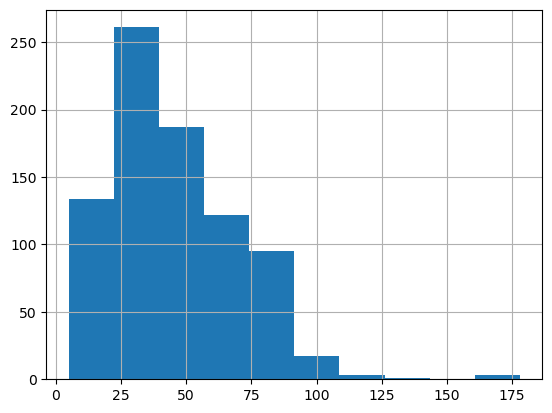

In [91]:
int_val.loc[impression_w_rare& int_val['Impressions'].str.contains('-1'),'Impressions'].str.split().apply(len).hist()

In [92]:
int_val.loc[impression_w_rare,'Impressions'].head().values

array(['N30283-0 N36779-0 N36786-0 N41787-0 N42950-0 N43016-0 N46495-0 N46917-0 N51253-0',
       'N12682-0 N14056-0 N16854-0 N23629-0 N26063-0 N27908-0 N28580-0 N3174-0 N33297-0 N3380-0 N36786-0 N37233-0 N3865-0 N41717-0 N41979-0 N42698-0 N42950-0 N45612-0 N46917-0 N47195-0 N47612-0 N50719-0 N53630-0 N53754-0 N55322-0 N6471-0 N6532-0 N7330-0 N8595-0',
       'N13408-0 N15366-0 N1597-0 N17447-0 N2307-0 N2340-0 N37577-0 N41541-0 N42950-0 N45319-0 N53201-0 N56458-0 N56897-0 N57763-0 N60092-0 N6858-0 N6994-0',
       'N16854-0 N23629-0 N26063-0 N27742-0 N27908-0 N28307-1 N3174-0 N33297-0 N33486-0 N36786-0 N38915-0 N41717-0 N41979-0 N42950-0 N45612-0 N45868-0 N46917-0 N48049-0 N50719-0 N50797-0 N51253-0 N53630-0 N55322-0 N56391-0 N57007-0 N60747-0',
       'N10401-0 N11681-0 N12146-0 N12769-0 N13347-0 N13408-0 N13865-0 N14637-0 N17672-0 N21571-0 N22292-0 N2307-0 N25334-0 N26063-0 N26811-0 N27057-0 N27742-0 N27908-0 N28307-0 N2852-0 N28580-0 N28716-0 N30689-0 N31503-0 N33297-0 N33397-0 N334

In [112]:
aug_df.head()

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,full_text,already_done,enhanced_text,enhanced_id,semi_enhanced_text,change_topic_id,changed_topic_text,from_large
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...,True,As the conflict in Ukraine continues to escal...,0.0,The conflict in Ukraine continues to escalate...,7.0,Ukraine's Lt. Ivan Molchanets Faces Financial...,True
7,N59295,news,newsworld,Chile: Three die in supermarket fire amid prot...,Three people have died in a supermarket fire a...,https://assets.msn.com/labs/mind/AAJ43pw.html,"[{""Label"": ""Chile"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Santiago"", ""Type"": ""G"", ""WikidataI...",Chile: Three die in supermarket fire amid prot...,True,Chile: Three die in supermarket fire amid ong...,1.0,"According to unconfirmed reports, three indiv...",7.0,Chile's Santiago-Based Bankruptcy: A Lesson L...,True
9,N39237,news,newsscienceandtechnology,"How to report weather-related closings, delays","When there are active closings, view them here...",https://assets.msn.com/labs/mind/AAlErhA.html,[],"[{""Label"": ""WXII-TV"", ""Type"": ""M"", ""WikidataId...","How to report weather-related closings, delays...",True,WXII 12 News receives numerous phone calls an...,2.0,WXII 12 News receives numerous phone calls an...,6.0,WXII 12 News: New Tariffs on Chinese Goods Co...,True
20,N9786,news,newspolitics,Elijah Cummings to lie in state at US Capitol ...,"Cummings, a Democrat whose district included s...",https://assets.msn.com/labs/mind/AAJgNxm.html,"[{""Label"": ""Elijah Cummings"", ""Type"": ""P"", ""Wi...","[{""Label"": ""Elijah Cummings"", ""Type"": ""P"", ""Wi...",Elijah Cummings to lie in state at US Capitol ...,True,"Elijah Cummings, a prominent Democrat whose d...",3.0,An event that impacts a significant number of...,0.0,Elijah Cummings' Impact on Political and Econ...,True
23,N42474,news,newsbusiness,Trump's Trustbusters Bring Microsoft Lessons t...,DOJ's Makan Delrahim and the FTC's Joe Simons ...,https://assets.msn.com/labs/mind/AACI1SK.html,"[{""Label"": ""Big Four tech companies"", ""Type"": ...","[{""Label"": ""Makan Delrahim"", ""Type"": ""P"", ""Wik...",Trump's Trustbusters Bring Microsoft Lessons t...,True,The recent decision by the DOJ's Makan Delrah...,3.0,The recent decision by the DOJ's Makan Delrah...,1.0,"""Trump's Big Lessons on Natural Disasters: Ho...",True


In [113]:
aug_df['semi_enhanced_text'].iloc[0]

" The conflict in Ukraine continues to escalate, and the Trump administration's decision to freeze aid to the country has left many soldiers on the front lines struggling to survive. The aid freeze has had a significant impact on the Ukrainian military's ability to defend against the Russian-backed separatists. The freeze cut off funding for critical supplies, including ammunition, medical equipment, and communication equipment. This has led to a significant decline in morale and a rise in desertions among the soldiers on the front lines. Despite the challenges, the Ukrainian military has continued to fight bravely. The aid freeze has made their job more difficult, but they have found ways to adapt and survive. The long-term effects of the aid freeze are uncertain, but it is clear that the soldiers on the front lines will continue to fight bravely, no matter what challenges they face."

In [124]:
batch = tokenizer(aug_df['changed_topic_text'].iloc[0], max_length=130,padding=True,truncation=True,return_tensors='pt')

In [125]:
tokenizer.decode(batch['input_ids'][0])

"[CLS] Ukraine's Lt. Ivan Molchanets Faces Financial Uncertainty as Major Company Goes Bankrupt In recent years, Ukraine has been grappling with a series of sudden corporate bankruptcies that have left many individuals and businesses in a state of financial uncertainty. One such company is the Ukrainian defense contractor, Lt. Ivan Molchanets, which has recently filed for bankruptcy. The collapse of Lt. Ivan Molchanets has had a ripple effect on the Ukrainian economy and financial markets. The company was a major supplier of weapons and military equipment to the Ukrainian government, and its bankruptcy has left many government officials and military leaders scrambling to find alternative sources of supply. The[SEP]"

In [123]:
len(tokenizer.decode(batch['input_ids'][0]).split())

109

In [1]:
import pandas as pd

In [2]:
hard_test = pd.read_pickle('classified_like_impactful_events_hard_test_from_dev.pkl')

In [3]:
len(hard_test)

75

In [4]:
hard_test.head()

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,full_text,rare_event_score
19984,N13697,finance,markets,Elizabeth Warren alarmed about turmoil in over...,Elizabeth Warren fears Wall Street will use th...,https://assets.msn.com/labs/mind/AAJbhik.html,[],"[{""Label"": ""Wall Street"", ""Type"": ""S"", ""Wikida...",Elizabeth Warren alarmed about turmoil in over...,0.002246
40107,N42950,finance,finance-companies,Climate change looms over giant Saudi energy IPO,As investors weigh up the value of Saudi energ...,https://assets.msn.com/labs/mind/BBWMngi.html,"[{""Label"": ""Initial public offering"", ""Type"": ...","[{""Label"": ""Initial public offering"", ""Type"": ...",Climate change looms over giant Saudi energy I...,0.004840
20381,N12932,finance,markets,How the Trade War and a Changing China Are Roi...,The trade war and China's economic shift made ...,https://assets.msn.com/labs/mind/AAJByee.html,"[{""Label"": ""China\u2013United States trade war...","[{""Label"": ""United Nations Conference on Trade...",How the Trade War and a Changing China Are Roi...,0.005048
24098,N59132,news,newsscienceandtechnology,Faraday Future founder files for Chapter 11 ba...,Faraday Future founder Jia Yueting has filed f...,https://assets.msn.com/labs/mind/AAILMOY.html,"[{""Label"": ""Faraday Future"", ""Type"": ""O"", ""Wik...","[{""Label"": ""Faraday Future"", ""Type"": ""O"", ""Wik...",Faraday Future founder files for Chapter 11 ba...,0.005670
24806,N24238,finance,finance-real-estate,"Climate change will break the housing market, ...",Risk to the housing market from underestimated...,https://assets.msn.com/labs/mind/AAJHCCi.html,[],[],"Climate change will break the housing market, ...",0.008290


<Axes: >

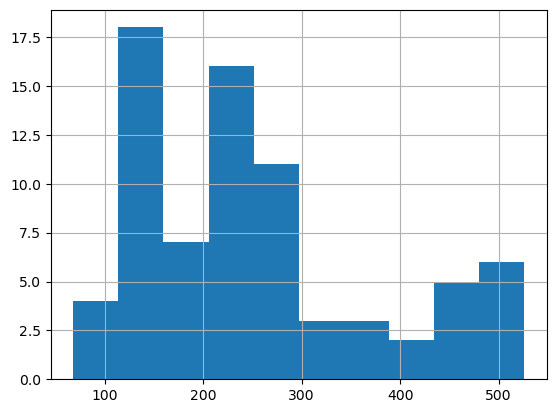

In [5]:
hard_test['full_text'].apply(len).hist()

<Axes: >

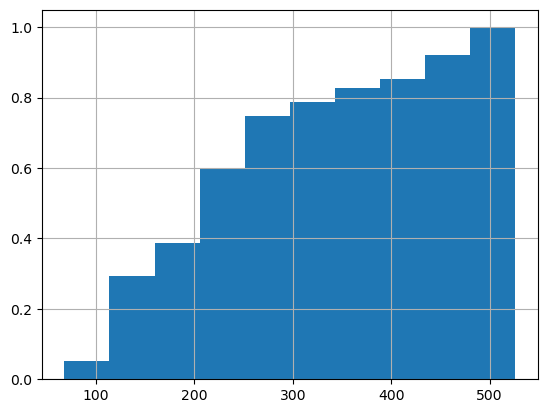

In [13]:
hard_test['full_text'].apply(len).hist(cumulative=True,density=True)

In [50]:
news= pd.read_table("data/MINDsmall_dev/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(42416, 15606, 2563)

In [51]:
useful_news = news.loc[news['Category'].isin(['news','finance'])].copy(deep=True)

In [52]:
(useful_news['Title'].isna() | useful_news['Abstract'].isna()).sum()

477

In [53]:
len(useful_news)

15606

In [54]:
477/15606

0.030565167243367934

In [55]:
useful_news['full_text'] = useful_news['Title'].fillna(" ")+" "+useful_news['Abstract'].fillna(" ")

In [64]:
((useful_news['Title'].fillna(" ").apply(len)<30)| (useful_news['Title'].fillna(" ").apply(len)<30)).sum()

169

<Axes: >

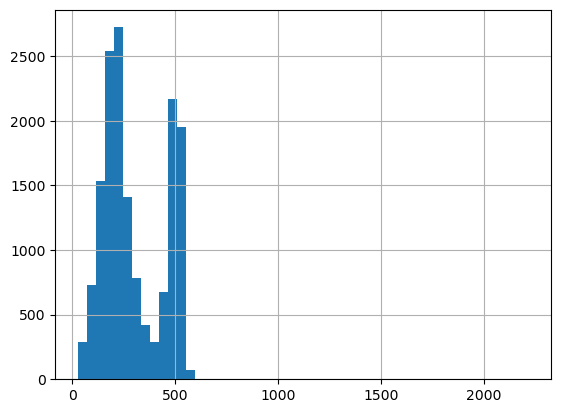

In [11]:
useful_news['full_text'].apply(len).hist(bins=50)

In [26]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Full dev set'}, xlabel='Character length'>

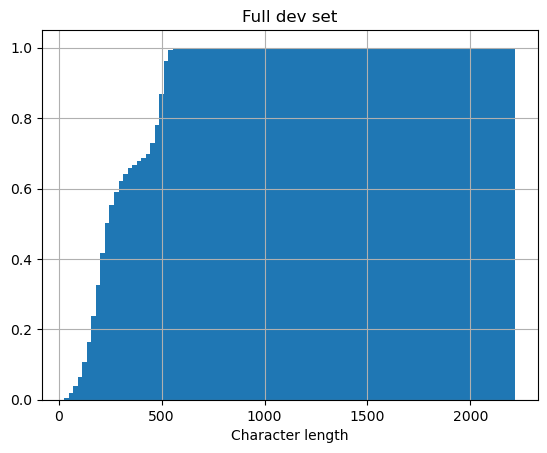

In [29]:
plt.title("Full dev set")
plt.xlabel("Character length")
useful_news['full_text'].apply(len).hist(cumulative=True,density=True,bins=100)

<Axes: title={'center': 'Rare events from dev set'}, xlabel='Character length'>

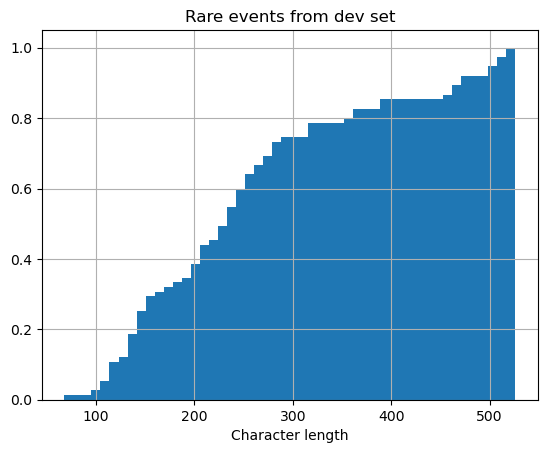

In [30]:
plt.title("Rare events from dev set")
plt.xlabel("Character length")
hard_test['full_text'].apply(len).hist(cumulative=True,density=True,bins=50)



In [ ]:
useful_news['full_text']

In [18]:
(useful_news['full_text'].apply(len)<200).sum()

4894

In [21]:
4894/len(useful_news)

0.31359733435858006

In [102]:
behaviors_cols = ["Impression ID","User ID","Time","History","Impressions" ]

In [105]:
interactions_test = pd.read_table("miner/data/test/behaviors.tsv",names=behaviors_cols)

In [109]:
dev_u_news = interactions_test['Impressions'].str.split().explode().apply(lambda x: x[:-2]).to_list()

In [111]:
useful_news.loc[useful_news['News ID'].isin(dev_u_news)].sort_values('rare_event_score')

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,full_text,rare_event_score
40107,N42950,finance,finance-companies,Climate change looms over giant Saudi energy IPO,As investors weigh up the value of Saudi energ...,https://assets.msn.com/labs/mind/BBWMngi.html,"[{""Label"": ""Initial public offering"", ""Type"": ...","[{""Label"": ""Initial public offering"", ""Type"": ...",Climate change looms over giant Saudi energy I...,0.004840
40416,N65103,finance,markets,Deere workers grapple with fallout from Trump'...,Deere workers grapple with fallout from Trump'...,https://assets.msn.com/labs/mind/BBWNOVn.html,"[{""Label"": ""John Deere"", ""Type"": ""O"", ""Wikidat...","[{""Label"": ""John Deere"", ""Type"": ""O"", ""Wikidat...",Deere workers grapple with fallout from Trump'...,0.008556
37461,N17720,finance,finance-companies,Big-name American companies that went bankrupt...,"Facing lawsuits, the changing retail industry ...",https://assets.msn.com/labs/mind/BBWPghW.html,[],[],Big-name American companies that went bankrupt...,0.013052
40762,N26286,finance,finance-real-estate,Climate change could end mortgages as we know ...,The traditional 30-year home loan along with...,https://assets.msn.com/labs/mind/BBWtoDQ.html,"[{""Label"": ""K\u00f6ppen climate classification...","[{""Label"": ""K\u00f6ppen climate classification...",Climate change could end mortgages as we know ...,0.015507
37605,N6994,finance,markets,Automakers around the world await Trump's tari...,Automakers around the world are awaiting a dec...,https://assets.msn.com/labs/mind/BBWOcz7.html,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...",Automakers around the world await Trump's tari...,0.025711
...,...,...,...,...,...,...,...,...,...,...
39524,N43801,news,newsus,Read the FBI's records of torture allegations ...,FBI documents show that ex-Chicago police Cmdr...,https://assets.msn.com/labs/mind/BBWP8vV.html,"[{""Label"": ""Jon Burge"", ""Type"": ""P"", ""Wikidata...","[{""Label"": ""Jon Burge"", ""Type"": ""P"", ""Wikidata...",Read the FBI's records of torture allegations ...,0.998507
37695,N63303,finance,finance-real-estate,A home-turned-rental is a better bet in Miami ...,A new study supports what many local real esta...,https://assets.msn.com/labs/mind/BBWOfbe.html,"[{""Label"": ""Miami"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Betterment (company)"", ""Type"": ""O""...",A home-turned-rental is a better bet in Miami ...,0.998520
38542,N9023,news,newsus,You have lots of questions about I-95 tolls. H...,Of all the questions our readers have about li...,https://assets.msn.com/labs/mind/BBWOyzf.html,"[{""Label"": ""Interstate 95"", ""Type"": ""S"", ""Wiki...","[{""Label"": ""Sun-Sentinel"", ""Type"": ""M"", ""Wikid...",You have lots of questions about I-95 tolls. H...,0.998532
38617,N58237,news,newscrime,"Suspicious deaths investigated in southern, ea...","CADDO, Okla. (AP) The Oklahoma State Bureau ...",https://assets.msn.com/labs/mind/BBWP08s.html,"[{""Label"": ""Oklahoma"", ""Type"": ""G"", ""WikidataI...","[{""Label"": ""Oklahoma State Bureau of Investiga...","Suspicious deaths investigated in southern, ea...",0.998538


In [112]:
useful_news.loc[useful_news['News ID'].isin(dev_u_news)].sort_values('rare_event_score')[["News ID","full_text","rare_event_score"]]

,News ID,full_text,rare_event_score
40107,N42950,Climate change looms over giant Saudi energy I...,0.004840
40416,N65103,Deere workers grapple with fallout from Trump'...,0.008556
37461,N17720,Big-name American companies that went bankrupt...,0.013052
40762,N26286,Climate change could end mortgages as we know ...,0.015507
37605,N6994,Automakers around the world await Trump's tari...,0.025711
...,...,...,...
39524,N43801,Read the FBI's records of torture allegations ...,0.998507
37695,N63303,A home-turned-rental is a better bet in Miami ...,0.998520
38542,N9023,You have lots of questions about I-95 tolls. H...,0.998532
38617,N58237,"Suspicious deaths investigated in southern, ea...",0.998538


In [113]:
useful_news.loc[useful_news['News ID'].isin(dev_u_news)].sort_values('rare_event_score')[["News ID","full_text","rare_event_score"]].to_csv('manual_classification_rare_news_set.csv')

In [189]:
news= pd.read_table("data/MINDlarge_dev/news.tsv",names=["News ID",
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities" ,
"Abstract Entities"])
(len(news),news['Category'].isin(['news','finance']).sum(),news['Category'].isin(['finance']).sum())

(72023, 26157, 4331)

In [190]:
useful_news = news.loc[news['Category'].isin(['news','finance'])].copy(deep=True)

In [191]:
useful_news['full_text'] = useful_news['Title'].fillna(" ")+" "+useful_news['Abstract'].fillna(" ")

In [192]:
all_pred = []

In [193]:



model.eval()
for i in range((len(useful_news)//32)+1):
    arts = useful_news['full_text'].iloc[i*32:(i+1)*32].to_list()
    batch = tokenizer(arts, max_length=512,padding=True,truncation=True,return_tensors='pt')

    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        pred = model(**batch)['logits'].detach().cpu()
    all_pred.extend( torch.sigmoid(pred[:,1]).tolist())

In [194]:
all_pred

[0.9982751607894897,
 0.9917486906051636,
 0.9977487921714783,
 0.9982522130012512,
 0.7957712411880493,
 0.9962421655654907,
 0.9984028935432434,
 0.9975276589393616,
 0.9979162812232971,
 0.9960952401161194,
 0.9982749223709106,
 0.9983123540878296,
 0.9960820078849792,
 0.9981682300567627,
 0.9981585144996643,
 0.9980448484420776,
 0.7268761396408081,
 0.9982341527938843,
 0.9977726340293884,
 0.9975544810295105,
 0.9846833348274231,
 0.9982106685638428,
 0.997996985912323,
 0.9760571718215942,
 0.9980668425559998,
 0.9872517585754395,
 0.9983460903167725,
 0.998455286026001,
 0.9976702332496643,
 0.998188316822052,
 0.9980310797691345,
 0.9982210993766785,
 0.9981786012649536,
 0.9982323050498962,
 0.9918563365936279,
 0.998261034488678,
 0.9852035045623779,
 0.9069458842277527,
 0.9782911539077759,
 0.9951005578041077,
 0.998132050037384,
 0.997514009475708,
 0.9268770217895508,
 0.9977555871009827,
 0.9984133243560791,
 0.9984277486801147,
 0.9984227418899536,
 0.9983376264572144

(array([   57.,    51.,   102.,   225.,   140.,   115.,   182.,   216.,
          395., 24674.]),
 array([0.00224594, 0.10187766, 0.20150938, 0.30114109, 0.40077281,
        0.50040453, 0.60003624, 0.69966796, 0.79929968, 0.89893139,
        0.99856311]),
 <BarContainer object of 10 artists>)

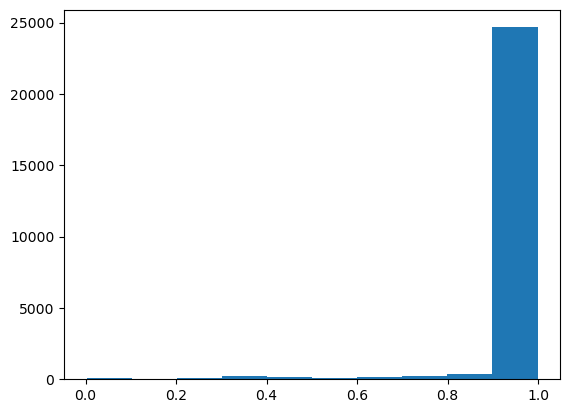

In [195]:
plt.hist(all_pred)

In [196]:
useful_news['rare_event_score'] = all_pred

In [197]:
rare_events_news  = useful_news.loc[useful_news['rare_event_score'] < 0.2,'News ID'].to_list() 

In [198]:
len(rare_events_news)

106

In [199]:
len(useful_news)

26157

In [200]:
useful_news.loc[useful_news['rare_event_score'] < 0.02].sort_values('rare_event_score').to_pickle('classified_like_impactful_events_large_sdev.pkl')

In [201]:
rare_events_news  = useful_news.loc[useful_news['rare_event_score'] < 0.1,'News ID'].to_list() 

In [202]:
len(rare_events_news)

57

In [203]:
len(useful_news)

26157

In [204]:
len(useful_news)

26157

In [205]:
useful_news.loc[useful_news['rare_event_score'] < 0.2].sort_values('rare_event_score').to_pickle('classified_like_impactful_events_large_hard_test_from_dev.pkl')

In [206]:
'data/large_filtered_behaviors_dev.tsv'

'data/large_filtered_behaviors_dev.tsv'

In [207]:
int_val = pd.read_csv("miner/data/test_large/behaviors.tsv",sep='\t',header=None,names=["Impression ID","User ID","Time","History","Impressions" ])

In [208]:
len(int_val)

332489

In [209]:
impression_w_rare= int_val['Impressions'].apply(lambda x: any([ article in x for article in rare_events_news]))

In [210]:
(impression_w_rare & int_val['Impressions'].str.contains('-1')).sum()

7420

In [211]:
int_val.loc[impression_w_rare & int_val['Impressions'].str.contains('-1')].to_csv("miner/data/test_large_hard/behaviors.tsv",sep='\t',index=False,header=False)

In [212]:
dev_u_news = int_val['Impressions'].str.split().explode().apply(lambda x: x[:-2]).to_list()

In [213]:
useful_news.loc[useful_news['News ID'].isin(dev_u_news)].sort_values('rare_event_score')[["News ID","full_text","rare_event_score"]].to_csv('manual_classification_large_rare_news_set.csv')

In [216]:
useful_news.loc[useful_news['News ID'].isin(dev_u_news)].sort_values('rare_event_score').head(25)

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities,full_text,rare_event_score
68368,N73295,finance,finance-companies,Climate change looms over giant Saudi energy IPO,As investors weigh up the value of Saudi energ...,https://assets.msn.com/labs/mind/BBWMngi.html,"[{""Label"": ""Initial public offering"", ""Type"": ...","[{""Label"": ""Initial public offering"", ""Type"": ...",Climate change looms over giant Saudi energy I...,0.004840
68813,N30982,finance,markets,Deere workers grapple with fallout from Trump'...,Deere workers grapple with fallout from Trump'...,https://assets.msn.com/labs/mind/BBWNOVn.html,"[{""Label"": ""John Deere"", ""Type"": ""O"", ""Wikidat...","[{""Label"": ""John Deere"", ""Type"": ""O"", ""Wikidat...",Deere workers grapple with fallout from Trump'...,0.008556
64905,N10209,finance,finance-companies,Big-name American companies that went bankrupt...,"Facing lawsuits, the changing retail industry ...",https://assets.msn.com/labs/mind/BBWPghW.html,[],[],Big-name American companies that went bankrupt...,0.013052
69369,N24516,finance,finance-real-estate,Climate change could end mortgages as we know ...,The traditional 30-year home loan along with...,https://assets.msn.com/labs/mind/BBWtoDQ.html,"[{""Label"": ""K\u00f6ppen climate classification...","[{""Label"": ""K\u00f6ppen climate classification...",Climate change could end mortgages as we know ...,0.015507
65090,N2059,finance,markets,Automakers around the world await Trump's tari...,Automakers around the world are awaiting a dec...,https://assets.msn.com/labs/mind/BBWOcz7.html,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...",Automakers around the world await Trump's tari...,0.025711
64799,N55377,finance,markets,This is what the trade war looks like in bourb...,After Europe retaliated with tariffs on Kentuc...,https://assets.msn.com/labs/mind/BBWLqIV.html,[],"[{""Label"": ""Lexington, Kentucky"", ""Type"": ""G"",...",This is what the trade war looks like in bourb...,0.031295
69449,N127861,news,newsworld,Defiant Venetians vow to stay despite flood de...,Defiant Venetians vow to stay despite flood de...,https://assets.msn.com/labs/mind/BBWLBej.html,[],[],Defiant Venetians vow to stay despite flood de...,0.035136
63681,N66470,finance,financenews,Lehigh Valley Dairy Farms part of bankruptcy f...,"America's largest milk producer, which this we...",https://assets.msn.com/labs/mind/BBWPQjW.html,"[{""Label"": ""Dean Foods"", ""Type"": ""O"", ""Wikidat...","[{""Label"": ""Dean Foods"", ""Type"": ""O"", ""Wikidat...",Lehigh Valley Dairy Farms part of bankruptcy f...,0.039926
65528,N88247,finance,markets,Climate change might hit the economy harder an...,The economic effects of global warming may arr...,https://assets.msn.com/labs/mind/BBWHHFf.html,[],"[{""Label"": ""Global warming"", ""Type"": ""C"", ""Wik...",Climate change might hit the economy harder an...,0.063504
655,N47407,finance,finance-billstopay,How millennials are changing banking,How millennials changed banking,https://assets.msn.com/labs/mind/AAHbP4O.html,[],[],How millennials are changing banking How mille...,0.095127


In [232]:
rare_events_news  = useful_news.loc[useful_news['rare_event_score'] < 0.09,'News ID'].to_list() 

In [233]:
len(rare_events_news)

54

In [234]:
len(useful_news)

26157

In [235]:
len(useful_news)

26157

In [236]:
useful_news.loc[useful_news['rare_event_score'] < 0.09].sort_values('rare_event_score').to_pickle('classified_like_impactful_events_large_hard_test_small_from_dev.pkl')

In [237]:
impression_w_rare= int_val['Impressions'].apply(lambda x: any([ article in x for article in rare_events_news]))

In [238]:
(impression_w_rare & int_val['Impressions'].str.contains('-1')).sum()

7418

In [239]:
int_val.loc[impression_w_rare & int_val['Impressions'].str.contains('-1')].to_csv("miner/data/test_large_hard_select/behaviors.tsv",sep='\t',index=False,header=False)